In [66]:
## In this notebook, the daily oisst will be compared with the features related to precipitation

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import scipy
from scipy import stats
from sklearn.metrics import r2_score
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import os
from matplotlib.colors import TwoSlopeNorm
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from multiprocessing import get_context

import matplotlib.patches as patches

In [68]:
num_cpus = mp.cpu_count()
print(f"Using {num_cpus} CPU cores for parallel processing")

Using 10 CPU cores for parallel processing


In [69]:
def create_climatology_dataset(xr_data, start_year=1998, end_year=2022):
    """
    Create a multi-annual dataset from two climatology NumPy arrays:
    - clim_365: climatology for common years (365 days)
    - clim_366: climatology for leap years (366 days)
    
    Parameters:
    -----------
    clim_365 : numpy.ndarray
        Array with shape (365, len(lat), len(lon)) for common years
    clim_366 : numpy.ndarray
        Array with shape (366, len(lat), len(lon)) for leap years
    lat : numpy.ndarray
        Latitude values
    lon : numpy.ndarray
        Longitude values
    start_year : int
        First year of the time series
    end_year : int
        Last year of the time series
    
    Returns:
    --------
    xarray.Dataset: Dataset with daily values for the specified period
    """
    daily_climatology = xr_data.groupby('time.dayofyear').mean(dim='time')
    daily_climatology_np_leap = daily_climatology.values
    day_of_year = np.arange(1, 367)
    day_of_year_non_leap = day_of_year!= 60
    clim_365 = daily_climatology_np_leap[day_of_year_non_leap, :,:]
    clim_366 = daily_climatology_np_leap
    lat = xr_data.latitude
    lon = xr_data.longitude
    




    # Create date range for the entire period
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    

    # Calculate total number of days
    total_days = len(dates)
    
    # Create an empty array to store the full time series data
    data = np.zeros((total_days, len(lat), len(lon)))
    
    # Current index in the data array
    idx = 0
    
    # Fill the data array year by year
    for year in range(start_year, end_year + 1):
        # Check if it's a leap year
        is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

        if is_leap_year:
            # Use 366-day climatology
            year_data = clim_366
            days_in_year = 366
        else:
            # Use 365-day climatology
            year_data = clim_365
            days_in_year = 365
        
        # Copy data for this year
        data[idx:idx+days_in_year] = year_data
        
        # Update index
        idx += days_in_year
    

    
    return xr_data - data



In [70]:
# Function to calculate r-squared for a grid cell
def calculate_r_squared_for_cell(nino_index, var_timeseries):
    """Calculate r-squared between NINO 3.4 index and a variable time series"""
    # Remove NaN values (both time series must have values)
    mask = ~np.isnan(var_timeseries) & ~np.isnan(nino_index)
    if np.sum(mask) < 10:  # Require at least 10 valid data points
        return np.nan
    
    # Calculate r-squared (square of correlation coefficient)
    try:
        r,_ = stats.pearsonr(nino_index[mask], var_timeseries[mask])
        return r
    except:
        return np.nan

In [71]:
def process_lat_slice(args):
    lat_idx, lat, nino_index, var_data = args
    r_squared_row = np.full(len(var_data.longitude), np.nan)
    
    for lon_idx, lon in enumerate(var_data.longitude.values):
        try:
            # Extract time series at this grid point
            grid_data = var_data.sel(latitude=lat, longitude=lon).values
            r_squared_row[lon_idx] = calculate_r_squared_for_cell(nino_index, grid_data)
        except Exception as e:
            r_squared_row[lon_idx] = np.nan
            print(f"Error processing lat_idx {lat_idx}, lon_idx {lon_idx}: {e}")
    return lat_idx, r_squared_row

In [88]:
# Function to calculate r-squared map for a single dataset
def calculate_r_squared_map(var_data, nino_index, index_for_anomaly):
    """Calculate r-squared map for a single variable dataset"""

    if index_for_anomaly:
        # Calculate anomalies
        var_data = create_climatology_dataset(var_data)
        print("Anomalies calculated")

    # Create an empty r-squared map
    r_squared_map = np.full((len(var_data.latitude), len(var_data.longitude)), np.nan)
    
    # Prepare arguments for parallel processing (by latitude)
    lat_args = [(lat_idx, lat, nino_index, var_data) 
                for lat_idx, lat in enumerate(var_data.latitude.values)]
    



    # Process in parallel
    with get_context("fork").Pool(num_cpus) as pool:
        results_lat = pool.map(process_lat_slice, lat_args)
    
    # Fill the r-squared map with results
    for lat_idx, r_squared_row in results_lat:
        r_squared_map[lat_idx, :] = r_squared_row
        
    return r_squared_map

In [73]:
mer_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/mer_tropical_box.nc')
sst_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/sst_daily_tropical_band_1998_2022.nc')
vimfc_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/vimfc_tropical_box.nc')
viqtend_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/viqtend_tropical_box.nc')
T_P_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/T_P_tropical_box.nc')
mer_tropical_box = -mer_tropical_box
viqtend_tropical_box = -viqtend_tropical_box
T_P_tropical_box = -T_P_tropical_box
vimfc_tropical_box = -vimfc_tropical_box
T_P_tropical_box = -T_P_tropical_box
vimfc_tropical_box = -vimfc_tropical_box

In [75]:
nino_data = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Analysis_near_greatbarrierreef/daily_nino_34/daily_nino34_oisst_98_22.nc')
# Extract the NINO 3.4 index values
nino_index = nino_data.values

In [76]:
from multiprocessing import get_context

def test(x):
    print(x)
    return x

# This will work in Jupyter
with get_context("fork").Pool(4) as p:
    results = p.map(test, range(4))
print("Done!")

1023



Done!


In [77]:
# Example usage
if __name__ == "__main__":
    # These would be your actual arrays
    # Example dimensions for illustration
    
    # Create the dataset
    anomaly_dataset = create_climatology_dataset(mer_tropical_box)
    


In [89]:
# Calculate r-squared maps
print("Calculating r-squared maps...")
r_squared_mer = calculate_r_squared_map(mer_tropical_box, nino_index, index_for_anomaly=True)
print("Finished calculating r-squared for mer")

r_squared_sst = calculate_r_squared_map(sst_tropical_box, nino_index, index_for_anomaly=True)
print("Finished calculating r-squared for sst")

r_squared_vimfc = calculate_r_squared_map(vimfc_tropical_box, nino_index, index_for_anomaly=True)
print("Finished calculating r-squared for vimfc")

r_squared_vidq_dt = calculate_r_squared_map(viqtend_tropical_box, nino_index, index_for_anomaly=True)
print("Finished calculating r-squared for vidq_dt")

r_squared_tp = calculate_r_squared_map(T_P_tropical_box, nino_index, index_for_anomaly=True)
print("Finished calculating r-squared for tp")

Calculating r-squared maps...
Anomalies calculated
Finished calculating r-squared for mer
Anomalies calculated
Finished calculating r-squared for sst
Anomalies calculated
Finished calculating r-squared for vimfc
Anomalies calculated
Finished calculating r-squared for vidq_dt
Anomalies calculated
Finished calculating r-squared for tp


In [90]:
results_anomaly = [
    (r_squared_mer, mer_tropical_box.latitude.values, mer_tropical_box.longitude.values, 'mer'),
    (r_squared_sst, sst_tropical_box.latitude.values, sst_tropical_box.longitude.values, 'sst'),
    (r_squared_vimfc, vimfc_tropical_box.latitude.values, vimfc_tropical_box.longitude.values, 'vimfc'),
    (r_squared_vidq_dt, viqtend_tropical_box.latitude.values, viqtend_tropical_box.longitude.values, 'vidq_dt'),
    (r_squared_tp, T_P_tropical_box.latitude.values, T_P_tropical_box.longitude.values, 'tp')
]

Creating visualization with Cartopy...


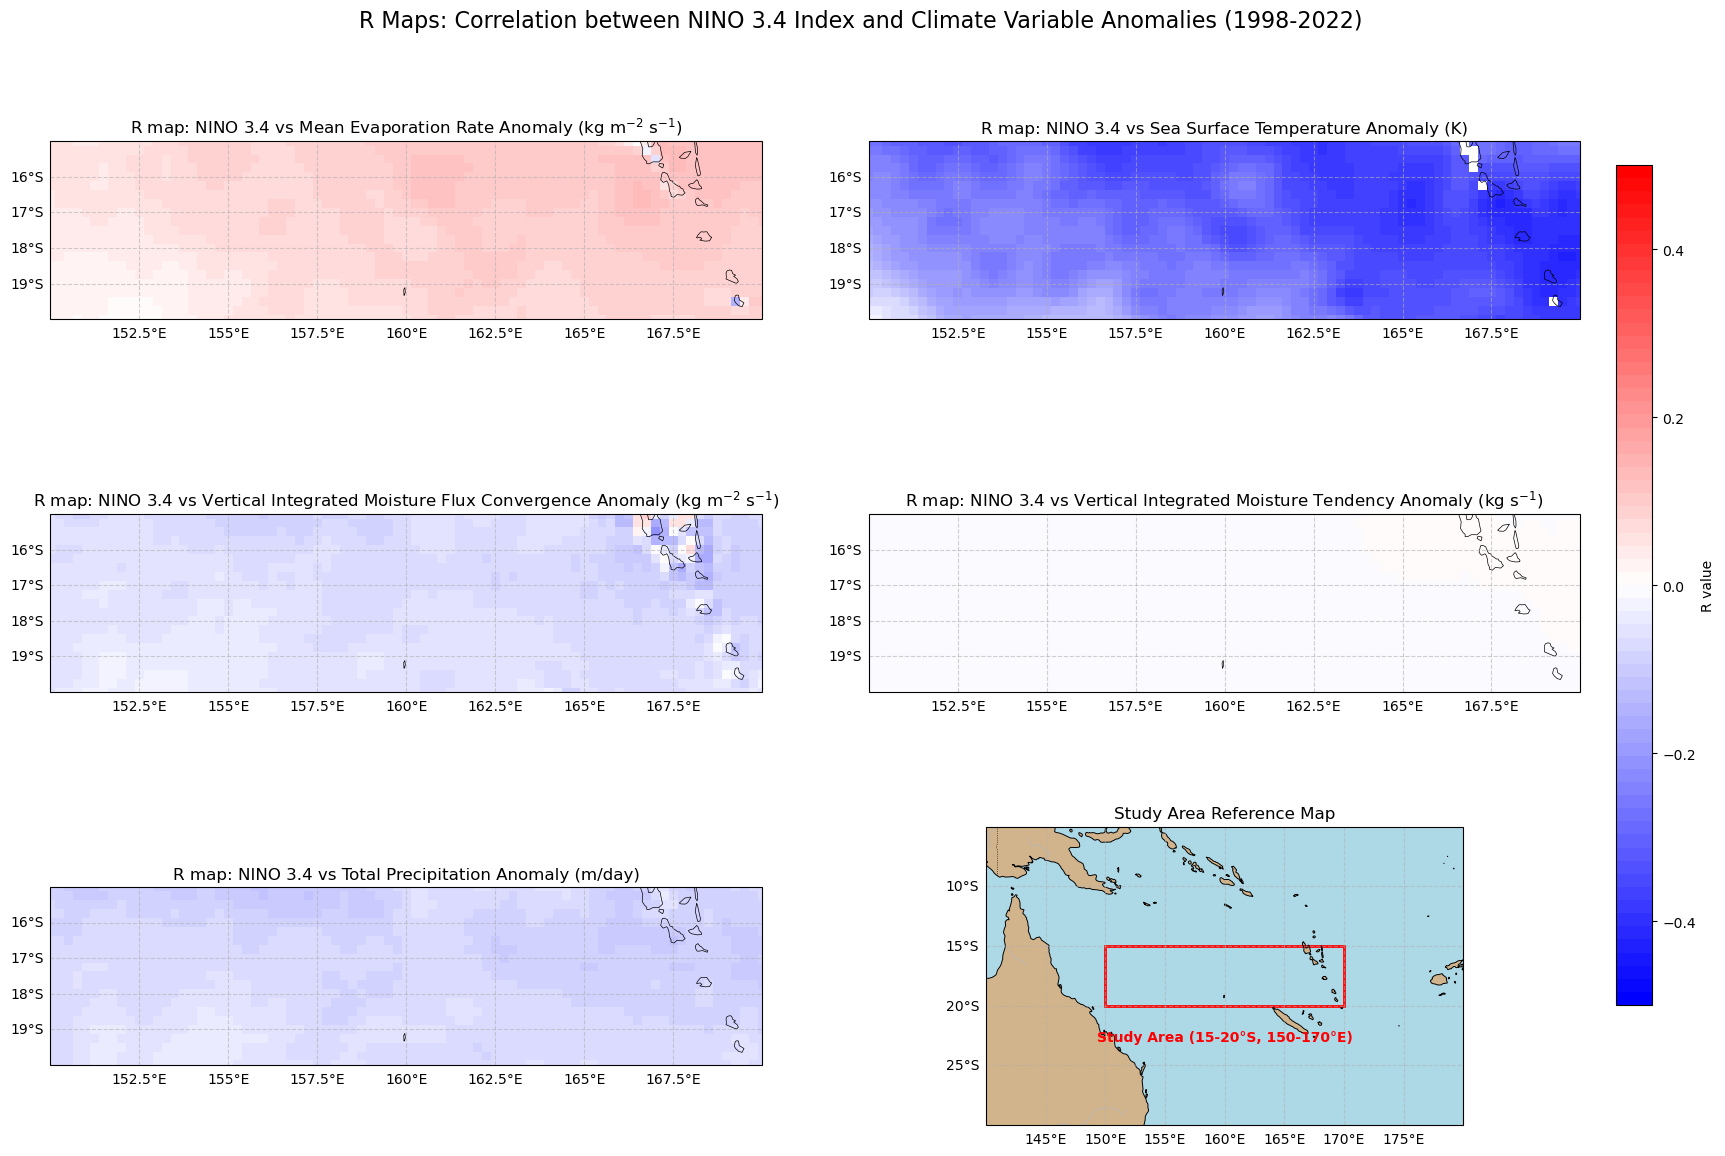

R analysis completed and visualized with Cartopy.


In [ ]:
var_titles = {
    'mer': 'Mean Evaporation Rate Anomaly (kg m$^{-2}$ s$^{-1}$)',
    'sst': 'Sea Surface Temperature Anomaly (K)',
    'vimfc': 'Vertical Integrated Moisture Flux Convergence Anomaly (kg m$^{-2}$ s$^{-1}$)',
    'vidq_dt': 'Vertical Integrated Moisture Tendency Anomaly (kg s$^{-1}$)',
    'tp': 'Total Precipitation Anomaly (m/day)'
}

# Create a custom colormap for r values
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]
cmap = LinearSegmentedColormap.from_list('r_cmap', colors, N=64)

# Define the study region bounds
study_region_bounds = (150, 170, -20, -15)  # (lon_min, lon_max, lat_min, lat_max)

# Create figure with Cartopy projections
print("Creating visualization with Cartopy...")
fig = plt.figure(figsize=(18, 12))

# Plot each correlation map using Cartopy
for i, (r_map, lats, lons, var_name) in enumerate(results_anomaly):
    if i >= 5:  # Only plot the first 5 variables
        break
    
    # Create subplot with Cartopy projection
    ax = fig.add_subplot(3, 2, i+1, projection=ccrs.PlateCarree())
    
    # Add coastlines and borders for reference
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    
    # Create mesh grid for plotting
    lon_mesh, lat_mesh = np.meshgrid(lons, lats)
    
    # Plot r map
    im = ax.pcolormesh(lon_mesh, lat_mesh, r_map, 
                       cmap=cmap, vmin=-0.5, vmax=0.5, 
                       transform=ccrs.PlateCarree())
    
    # Add gridlines with labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.6, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
    # Set title
    ax.set_title(f"R map: NINO 3.4 vs {var_titles[var_name]}")
    
    # Set map extent to the study region
    ax.set_extent(study_region_bounds, crs=ccrs.PlateCarree())

# Define wider context bounds for the reference map
context_bounds = (
    study_region_bounds[0] - 10,  # Extend 30 degrees west
    study_region_bounds[1] + 10,  # Extend 20 degrees east
    study_region_bounds[2] - 10,  # Extend 15 degrees south
    study_region_bounds[3] + 10   # Extend 20 degrees north
)

# Create reference map in the 6th position
ax = fig.add_subplot(3, 2, 6, projection=ccrs.PlateCarree())

# Add natural earth features for better visualization
ax.add_feature(cfeature.LAND, facecolor='tan')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.coastlines(resolution='50m', color='black', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.7)
ax.add_feature(cfeature.RIVERS, linewidth=0.5, alpha=0.5)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Highlight the study region with a red rectangle
ax.add_patch(patches.Rectangle(
    xy=[study_region_bounds[0], study_region_bounds[2]],
    width=study_region_bounds[1] - study_region_bounds[0],
    height=study_region_bounds[3] - study_region_bounds[2],
    facecolor='none',
    edgecolor='red',
    linewidth=2,
    transform=ccrs.PlateCarree()
))

# Add text annotation for the study area
ax.text(
    (study_region_bounds[0] + study_region_bounds[1])/2,
    study_region_bounds[2] - 3,
    'Study Area (15-20°S, 150-170°E)',
    horizontalalignment='center',
    transform=ccrs.PlateCarree(),
    fontsize=10,
    color='red',
    fontweight='bold'
)

# Add labels for major regions

# Set the map extent for the reference map
ax.set_extent(context_bounds, crs=ccrs.PlateCarree())

# Set title for reference map
ax.set_title('Study Area Reference Map')

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('R value')

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.92, wspace=0.15, hspace=0.25)

# Add overall title
fig.suptitle('R Maps: Correlation between NINO 3.4 Index and Climate Variable Anomalies (1998-2022)', 
            fontsize=16, y=0.98)

# Save the figure
plt.savefig('nino34_r_maps_cartopy.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print("R analysis completed and visualized with Cartopy.")

In [ ]:
ssta = create_climatology_dataset(sst_tropical_box)

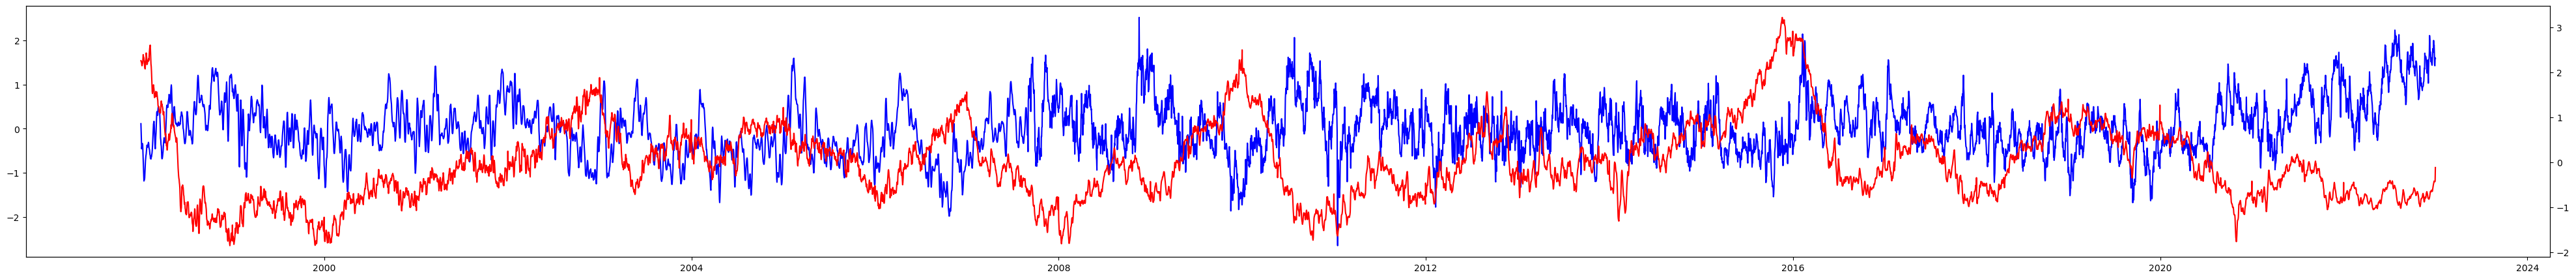

In [ ]:
fig, ax1 = plt.subplots(figsize=(50, 5))
ax2 = ax1.twinx()
ax1.plot(mer_tropical_box.time, ssta[:,15,70].values, label='mer', color='blue')
ax2.plot(mer_tropical_box.time, nino_index, label='nino', color='red')